In [1]:
#Library
import pandas as pd

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import seaborn
import numpy as np

from sklearn.linear_model import LinearRegression
from scipy.stats import multivariate_normal

In [68]:
#Dataset import on pandas Data frames
DatasetCyclists = pd.read_csv("dataset/cyclists.csv")
DatasetRace = pd.read_csv("dataset/races.csv")

### Plot tools

In [3]:
def PlotMissingUsableData(Dataset, Name):
    
    PlotDataset = pd.DataFrame({
        "Elements": list(Dataset.keys()),
        "Total values": [Dataset.shape[0]]*len(list(Dataset.keys())),
        "Missing values": list(Dataset.isnull().sum()),
        "Usable values": list(Dataset.shape[0] - Dataset.isnull().sum())
    })

    PlotDataset.set_index('Elements', inplace=True)
    PlotDataset.plot(kind='bar', figsize=(10, 6))
    
    print(PlotDataset)

    plt.title(f'Dataset {Name} distribution')
    plt.xlabel('Features')
    plt.ylabel('Valori')
    plt.show()

In [4]:
def PlotDistributionFeatures(Dataset, Features):
    
    PlotsLambda = [lambda f, ax: ax.hist(Dataset[f], bins = 10, alpha = 0.7, color = "blue")
                   ]

    fig = plt.figure(figsize = (3*len(PlotsLambda), 2*len(Features)))   #Altezza, larghezza
    gs = gridspec.GridSpec(len(Features), len(PlotsLambda), figure=fig)
      
    i = 0

    for feature in Features:
        
        
        ax = fig.add_subplot(gs[i//len(PlotsLambda), i%len(PlotsLambda)])
        ax.set_title(feature) 
        
        for plot in PlotsLambda:    
            plot(feature, ax)
            
            i += 1

    plt.tight_layout()  # Per evitare sovrapposizioni
    plt.show()
    
    Fs = []
    i = 0
    r = 4
    

    while(i+r < len(Features)):
        Fs.append(Features[i: i+r])
        i += r
        
    if(i < len(Features)-1): Fs.append(Features[i:])
    
    Dataset = (Dataset[Features] - Dataset[Features].mean()) / Dataset[Features].std()
    
    for fs in Fs:
    
        seaborn.boxenplot(Dataset[fs], orient="h")
        plt.show()
        
        seaborn.catplot(Dataset[fs], kind="box") 
        plt.show()
    

# **Data understanding**

## Dataset cyclists

### Missing values distributions

In [5]:
DatasetCyclists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134 entries, 0 to 6133
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   _url         6134 non-null   object 
 1   name         6134 non-null   object 
 2   birth_year   6121 non-null   float64
 3   weight       3078 non-null   float64
 4   height       3143 non-null   float64
 5   nationality  6133 non-null   object 
dtypes: float64(3), object(3)
memory usage: 287.7+ KB


             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134            3056           3078
height               6134            2991           3143
nationality          6134               1           6133


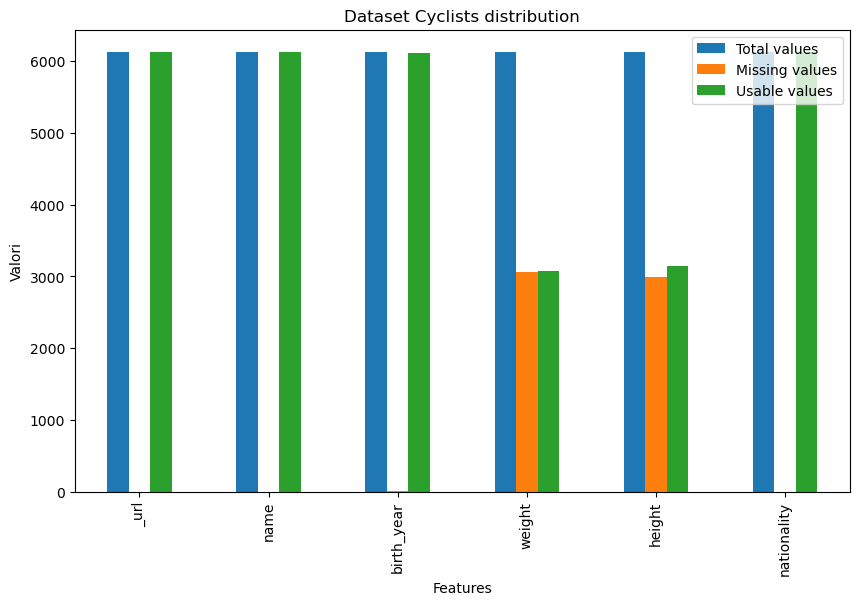

In [6]:
PlotMissingUsableData(DatasetCyclists, "Cyclists")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "weight" e "height".
- Nella colonna "birth_year" manca qualche dato e su "nationality" un solo dato.

### Correct values check (Margherita)

In [30]:
DatasetCyclists.head()

,_url,name,birth_year,weight,height,nationality
0,bruno-surra,Bruno Surra,1964.0,NaN,NaN,Italy
1,gerard-rue,Gérard Rué,1965.0,74.0,182.0,France
2,jan-maas,Jan Maas,1996.0,69.0,189.0,Netherlands
3,nathan-van-hooydonck,Nathan Van Hooydonck,1995.0,78.0,192.0,Belgium
4,jose-felix-parra,José Félix Parra,1997.0,55.0,171.0,Spain


In [13]:
DatasetCyclists.describe()
#possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili

,birth_year,weight,height
count,6121.000000,3078.000000,3143.000000
mean,1974.071884,68.658739,179.815145
std,15.535834,6.348183,6.443447
min,1933.000000,48.000000,154.000000
25%,1962.000000,64.000000,175.000000
50%,1974.000000,69.000000,180.000000
75%,1987.000000,73.000000,184.000000
max,2004.000000,94.000000,204.000000


In [21]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetCyclists:\n", DatasetCyclists.isnull().sum())


Valori mancanti in DatasetCyclists:
 _url              0
name              0
birth_year       13
weight         3056
height         2991
nationality       1
dtype: int64


In [22]:
# controllo Duplicati
print("Duplicati in DatasetCyclists:", DatasetCyclists.duplicated().sum())


Duplicati in DatasetCyclists: 0


In [53]:
# Controllo del formato dei nomi
import re

# Regex che include lettere latine estese e trattini
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'-]+$")

invalid_names = DatasetCyclists[~DatasetCyclists['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names[['name']].shape[0])


Numero di nomi non validi:
 0


In [55]:
from unidecode import unidecode

# Crea la colonna 'expected_url' generata dai valori in 'name' senza accenti
DatasetCyclists['expected_url'] = DatasetCyclists['name'].apply(lambda x: unidecode(x.lower()).replace(' ', '-'))

# Trova righe in cui '_url' non coincide con 'expected_url'
invalid_urls = DatasetCyclists[DatasetCyclists['_url'] != DatasetCyclists['expected_url']]

# Conta e stampa le righe con discrepanze
print("Numero di URL non conformi:", len(invalid_urls))
print("Esempi di URL non conformi:\n", invalid_urls[['_url', 'name', 'expected_url']].head(10))


Numero di URL non conformi: 559
Esempi di URL non conformi:
                            _url                 name         expected_url
25                 graeme-brown   Graeme Allen Brown   graeme-allen-brown
49    jesus-rodriguez-rodriguez      Jesús Rodríguez      jesus-rodriguez
68        iban-herrero-atienzar         Ivan Herrero         ivan-herrero
88          juan-ayuso-pesquera           Juan Ayuso           juan-ayuso
106     anselmo-fuerte-abelenda       Anselmo Fuerte       anselmo-fuerte
126  luis-ricardo-mesa-saavedra    Luis Ricardo Mesa    luis-ricardo-mesa
127         joseba-lopez-cuesta         Joseba López         joseba-lopez
160                yecid-sierra  Yecid Arturo Sierra  yecid-arturo-sierra
172                 manuel-mesa     José Manuel Mesa     jose-manuel-mesa
178              willy-in-t-ven      Willy In 't Ven      willy-in-'t-ven


In [35]:
#controllo dei valori di 'nationality' (non ho altre idee per farlo)

unique_nationalities = DatasetCyclists['nationality'].unique()
print("Nazionalità uniche:\n", unique_nationalities)


Nazionalità uniche:
 ['Italy' 'France' 'Netherlands' 'Belgium' 'Spain' 'United States' nan
 'Norway' 'Russia' 'Poland' 'Germany' 'Australia' 'Switzerland' 'Ireland'
 'Denmark' 'Great Britain' 'Colombia' 'South Africa' 'Argentina'
 'New Zealand' 'Lithuania' 'Portugal' 'Austria' 'Yugoslavia' 'Estonia'
 'Romania' 'Slovenia' 'Canada' 'Latvia' 'Luxembourg' 'Sweden'
 'Czech Republic' 'Slovakia' 'Morocco' 'Ukraine' 'Ethiopia' 'Belarus'
 'Venezuela' 'Japan' 'Mexico' 'Croatia' 'Kazakhstan' 'Uruguay' 'Israel'
 'Namibia' 'Eritrea' 'Costa Rica' 'Taiwan' 'Azerbaijan' 'Hungary'
 'Moldova' 'Panama' 'Finland' 'Bulgaria' 'Serbia' 'Brazil' 'Iran' 'Greece'
 'Chile' 'Ecuador' 'China' 'Albania' 'Guatemala' 'Uzbekistan' 'Algeria'
 'Tunisia' 'Monaco' 'Rwanda' 'Dominican Republic' 'Liechtenstein'
 'Zimbabwe' 'Puerto Rico' 'Hongkong']


### Features distributions

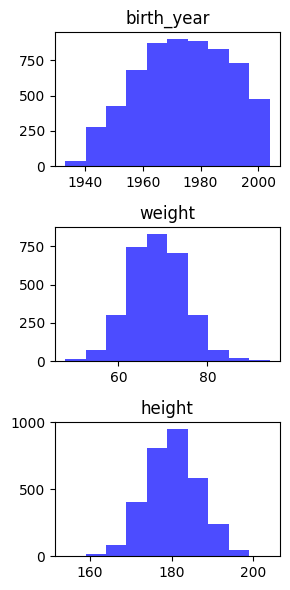

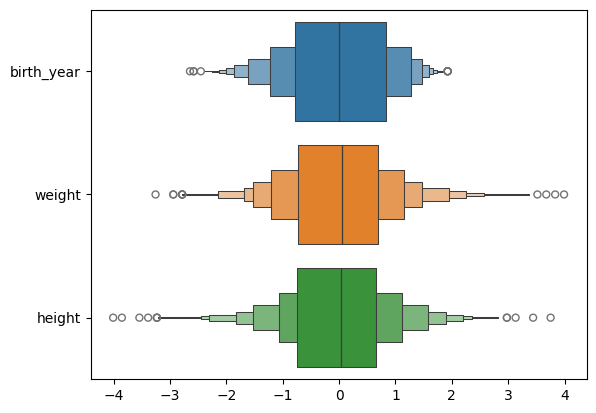

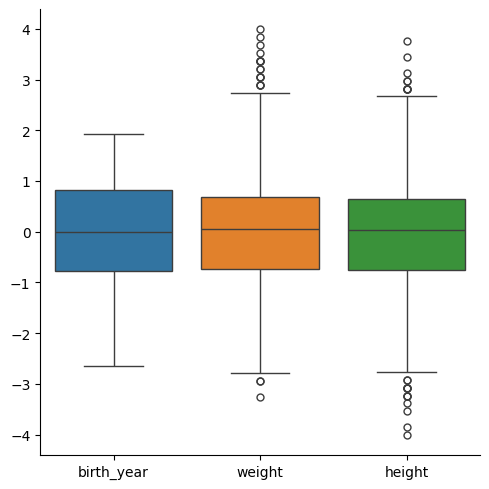

In [14]:
InterestingFeatures = ["birth_year", "weight", "height"]

PlotDistributionFeatures(DatasetCyclists, InterestingFeatures)

Le distribuzioni seguono tutte una distribuzione gaussiana è la presenza di outlier è più (ma non troppo) presente sulle colonne "weight" e "height".

### Correlations between features (Oleskiy)

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **cyclists**:

- 

## Dataset race

### Missing values distributions

In [7]:
DatasetRace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589865 entries, 0 to 589864
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _url                 589865 non-null  object 
 1   name                 589865 non-null  object 
 2   points               589388 non-null  float64
 3   uci_points           251086 non-null  float64
 4   length               589865 non-null  float64
 5   climb_total          442820 non-null  float64
 6   profile              441671 non-null  float64
 7   startlist_quality    589865 non-null  int64  
 8   average_temperature  29933 non-null   float64
 9   date                 589865 non-null  object 
 10  position             589865 non-null  int64  
 11  cyclist              589865 non-null  object 
 12  cyclist_age          589752 non-null  float64
 13  is_tarmac            589865 non-null  bool   
 14  is_cobbled           589865 non-null  bool   
 15  is_gravel        

                     Total values  Missing values  Usable values
Elements                                                        
_url                       589865               0         589865
name                       589865               0         589865
points                     589865             477         589388
uci_points                 589865          338779         251086
length                     589865               0         589865
climb_total                589865          147045         442820
profile                    589865          148194         441671
startlist_quality          589865               0         589865
average_temperature        589865          559932          29933
date                       589865               0         589865
position                   589865               0         589865
cyclist                    589865               0         589865
cyclist_age                589865             113         589752
is_tarmac                

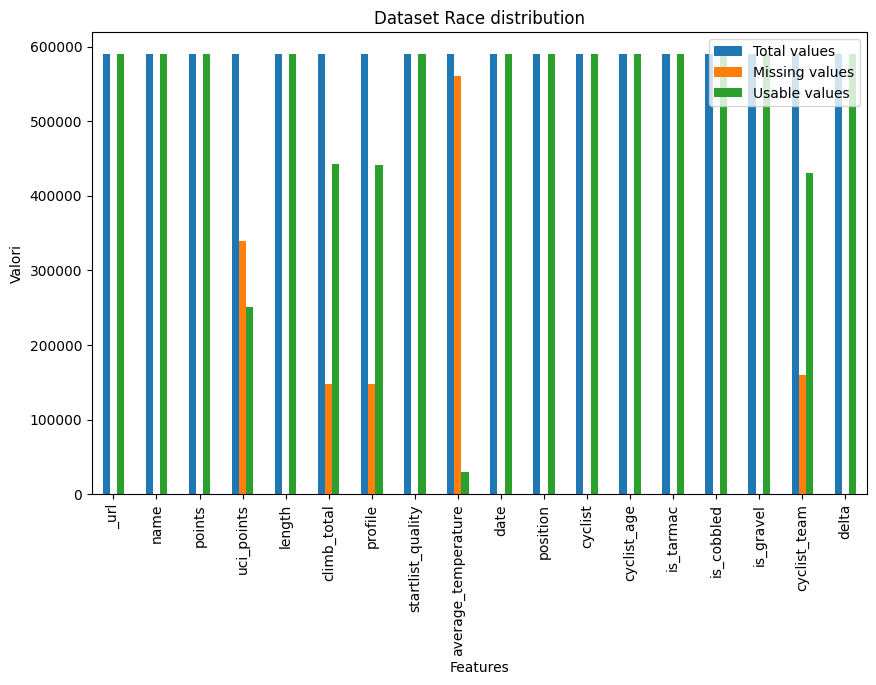

In [15]:
PlotMissingUsableData(DatasetRace, "Race")

Si può vedere che:

- La mancanza di dati è importante nelle colonne "uci_points", "average_temperature", "cyclists_team", "climb_total" e "profile".

### Correct values check (Margherita)

In [36]:
DatasetRace.head()

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
0,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,0,sean-kelly,22.0,True,False,False,vini-ricordi-pinarello-sidermec-1986,0.0
1,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,1,gerrie-knetemann,27.0,True,False,False,norway-1987,0.0
2,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,2,rene-bittinger,24.0,True,False,False,NaN,0.0
3,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,3,joseph-bruyere,30.0,True,False,False,navigare-blue-storm-1993,0.0
4,tour-de-france/1978/stage-6,Tour de France,100.0,NaN,162000.0,1101.0,1.0,1241,NaN,1978-07-05 04:02:24,4,sven-ake-nilsson,27.0,True,False,False,spain-1991,0.0


In [16]:
DatasetRace.describe()
'''possiamo vedere il valore minimo e massimo di ogni attributo numerico e constatare che sono valori ammissibili, 
dobbiamo capire il significato di delta<0'''

,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,position,cyclist_age,delta
count,589388.000000,251086.000000,589865.000000,442820.000000,441671.000000,589865.000000,29933.000000,589865.000000,589752.000000,589865.000000
mean,89.221635,74.601547,166776.180584,2330.469215,2.611611,1101.161178,21.731768,74.219491,28.486208,418.292794
std,54.435330,100.947962,64545.605664,1375.710722,1.491741,380.586928,5.884761,48.404023,3.855631,842.961596
min,18.000000,6.000000,1000.000000,2.000000,1.000000,115.000000,10.000000,0.000000,13.000000,-6906.000000
25%,50.000000,16.000000,152500.000000,1309.000000,1.000000,844.000000,17.000000,32.000000,26.000000,10.000000
50%,80.000000,60.000000,178200.000000,2255.000000,2.000000,988.000000,22.000000,70.000000,28.000000,156.000000
75%,100.000000,100.000000,203500.000000,3273.000000,4.000000,1309.000000,26.000000,112.000000,31.000000,624.000000
max,350.000000,800.000000,338000.000000,6974.000000,5.000000,2047.000000,36.000000,209.000000,56.000000,61547.000000


In [69]:
DatasetRace[DatasetRace["delta"] < 0]

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
70651,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:23,10,johan-bruyneel,28.0,True,False,False,ville-de-charleroi-new-systems-2000,-2635.0
70652,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:20,11,raul-alcala,28.0,True,False,False,team-volksbank-2008,-2638.0
70653,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:57,12,joachim-halupczok,24.0,True,False,False,NaN,-2541.0
70654,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:56,13,djamolidine-abduzhaparov,28.0,True,False,False,south-africa-2022,-2542.0
70655,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:53,14,guido-bontempi,32.0,True,False,False,south-africa-2022,-2545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229670,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,7,laurent-jalabert,22.0,True,False,False,kazakhstan-2022,-5562.0
229671,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,8,claudio-chiappucci,27.0,True,False,False,csf-group-navigare-2008,-5562.0
229672,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:32:39,9,jean-claude-colotti,29.0,True,False,False,jolly-ceramica-1977,-6906.0
413492,tour-de-france/2003/stage-12,Tour de France,100.0,NaN,47000.0,712.0,2.0,1688,NaN,2003-07-18 00:09:35,104,leonardo-bertagnolli,25.0,True,False,False,team-saxo-bank-tinkoff-bank-2012,-2937.0


In [74]:
pos = DatasetRace["position"] == 0
d = DatasetRace["delta"] != 0
print("numero di righe dove la posizione è 0 e delta è diverso da zero: ",DatasetRace[pos & d].shape[0])

numero di righe dove la posizione è 0 e delta è diverso da zero:  0


In [72]:
DatasetRace[DatasetRace["delta"] < 0]
#controllando su google Tour de France 2003 leonardo bertagnolli squalificato
#Vuelta a España 1992 guido bontempi arrivato 62° anche se il dataset indica position=14
#Tour de Suisse 1993 marco saligari ha vinto ma delta = -106.0

,_url,name,points,uci_points,length,climb_total,profile,startlist_quality,average_temperature,date,position,cyclist,cyclist_age,is_tarmac,is_cobbled,is_gravel,cyclist_team,delta
70651,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:23,10,johan-bruyneel,28.0,True,False,False,ville-de-charleroi-new-systems-2000,-2635.0
70652,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:02:20,11,raul-alcala,28.0,True,False,False,team-volksbank-2008,-2638.0
70653,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:57,12,joachim-halupczok,24.0,True,False,False,NaN,-2541.0
70654,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:56,13,djamolidine-abduzhaparov,28.0,True,False,False,south-africa-2022,-2542.0
70655,vuelta-a-espana/1992/stage-19,Vuelta a España,80.0,NaN,37900.0,294.0,NaN,1033,NaN,1992-05-15 00:03:53,14,guido-bontempi,32.0,True,False,False,south-africa-2022,-2545.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229670,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,7,laurent-jalabert,22.0,True,False,False,kazakhstan-2022,-5562.0
229671,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:55:03,8,claudio-chiappucci,27.0,True,False,False,csf-group-navigare-2008,-5562.0
229672,paris-nice/1990/stage-7a,Paris - Nice,50.0,NaN,102000.0,NaN,NaN,995,NaN,1990-03-11 00:32:39,9,jean-claude-colotti,29.0,True,False,False,jolly-ceramica-1977,-6906.0
413492,tour-de-france/2003/stage-12,Tour de France,100.0,NaN,47000.0,712.0,2.0,1688,NaN,2003-07-18 00:09:35,104,leonardo-bertagnolli,25.0,True,False,False,team-saxo-bank-tinkoff-bank-2012,-2937.0


In [71]:
# Ordinare il dataset per 'position' e 'delta'
tour = DatasetRace[DatasetRace['_url'] == "vuelta-a-espana/1992/stage-19"]
#tour['delta'] = tour['delta'].abs()
print(tour[['_url', 'position', 'delta']])
#print(tour[tour['delta']<0])
DatasetRace_sorted = tour.sort_values(by=['position', 'delta'])

# Controlla che il delta sia crescente all'aumentare della posizione
invalid_deltas = DatasetRace_sorted[DatasetRace_sorted['delta'].diff() < 0]

# Filtrare per mostrare solo i casi in cui la posizione aumenta
invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]

print("Numero di righe con delta non coerente rispetto alla posizione:", len(invalid_deltas))
print("Esempi di righe con delta non coerente:\n", invalid_deltas[['_url', 'position', 'delta']].head())


                                _url  position   delta
70641  vuelta-a-espana/1992/stage-19         0     0.0
70642  vuelta-a-espana/1992/stage-19         1    52.0
70643  vuelta-a-espana/1992/stage-19         2    68.0
70644  vuelta-a-espana/1992/stage-19         3    93.0
70645  vuelta-a-espana/1992/stage-19         4   100.0
...                              ...       ...     ...
70721  vuelta-a-espana/1992/stage-19        80 -2385.0
70722  vuelta-a-espana/1992/stage-19        81 -2391.0
70723  vuelta-a-espana/1992/stage-19        82 -2393.0
70724  vuelta-a-espana/1992/stage-19        83 -2394.0
70725  vuelta-a-espana/1992/stage-19        84 -2397.0

[85 rows x 3 columns]
Numero di righe con delta non coerente rispetto alla posizione: 61
Esempi di righe con delta non coerente:
                                 _url  position   delta
70651  vuelta-a-espana/1992/stage-19        10 -2635.0
70652  vuelta-a-espana/1992/stage-19        11 -2638.0
70654  vuelta-a-espana/1992/stage-19        

C:\Users\hp\AppData\Local\Temp\ipykernel_10052\1041641539.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  invalid_deltas = invalid_deltas[DatasetRace_sorted['position'].diff() > 0]


In [19]:
# Controllo dei valori mancanti
print("Valori mancanti in DatasetRace:\n", DatasetRace.isnull().sum())


Valori mancanti in races:
 _url                        0
name                        0
points                    477
uci_points             338779
length                      0
climb_total            147045
profile                148194
startlist_quality           0
average_temperature    559932
date                        0
position                    0
cyclist                     0
cyclist_age               113
is_tarmac                   0
is_cobbled                  0
is_gravel                   0
cyclist_team           159161
delta                       0
dtype: int64


In [20]:
# controllo dei Duplicati
print("Duplicati in DatasetRace:", DatasetRace.duplicated().sum())


Duplicati in races: 0


In [39]:
# _url
# Controllo che non ci siano spazi o caratteri non validi negli URL
invalid_urls = DatasetRace[~DatasetRace['_url'].str.match(r'^[\w/:.-]+$', na=False)]

# Stampa il numero di URL non validi
print("Numero di URL non validi:", invalid_urls.shape[0])


Numero di URL non validi: 0


In [43]:
# Controllo nomi 
import re
# Regex che include lettere latine estese, trattini e anche il carattere '/'
name_pattern = re.compile(r"^[\wÀ-ÖØ-öø-ÿ\s'/-]+$")

# Rieffettua il controllo dei nomi
invalid_names_race = DatasetRace[~DatasetRace['name'].str.match(name_pattern, na=False)]
print("Numero di nomi non validi:", invalid_names_race['name'].shape[0])


Numero di nomi non validi: 0


In [45]:
# Controllo che le date siano valide
invalid_dates = DatasetRace[~DatasetRace['date'].str.match(r'^\d{4}-\d{2}-\d{2}.*$', na=False)]
print("Numero di date non valide:", invalid_dates['date'].shape[0])


Numero di date non valide:
 0


In [47]:
# Controllo cyclist
invalid_cyclists = DatasetRace[~DatasetRace['cyclist'].str.match(r"^[\w-]+$", na=False)]
print("Numero di nomi dei ciclisti non validi:", invalid_cyclists['cyclist'].shape[0])


Numero di nomi dei ciclisti non validi:
 0


In [51]:
# Controllo team dei ciclisti
invalid_teams = DatasetRace[DatasetRace['cyclist_team'].notna() & ~DatasetRace['cyclist_team'].str.match(r"^[\w\s\-.&/]+$", na=False)]

print("Numero di team non validi in DatasetRace:", invalid_teams.shape[0])

Numero di team non validi in DatasetRace: 0


In [27]:
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_tarmac'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_cobbled'].isin([True, False])].shape[0])
print("Valori non booleani in DatasetRace:", DatasetRace[~DatasetRace['is_gravel'].isin([True, False])].shape[0])

Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0
Valori non booleani in DatasetRace: 0


In [58]:
# controllo se birth_year+cyclist_age=race_year
# Unione dei dataset sulla colonna 'name' e 'cyclist'
merged_data = pd.merge(DatasetRace, DatasetCyclists.rename(columns={'name': 'cyclist_name'}), left_on='cyclist', right_on='cyclist_name', how='inner')

merged_data['race_year'] = pd.to_datetime(merged_data['date']).dt.year

# Calcolo l'anno di nascita previsto (race_year - cyclist_age)
merged_data['expected_birth_year'] = merged_data['race_year'] - merged_data['cyclist_age']

# cercare le righe dove birth_year non corrisponde con l'expected_birth_year
invalid_birth_years = merged_data[merged_data['birth_year'] != merged_data['expected_birth_year']]

print("Numero di righe con discrepanze negli anni di nascita:")
print(invalid_birth_years[['cyclist_name', 'cyclist', 'birth_year', 'cyclist_age', 'race_year', 'expected_birth_year']].shape[0])


Numero di righe con discrepanze negli anni di nascita:
0


In [59]:
# controllo se almeno uno tra is_tarmac(asfalto), is_cobbled(acciottolato) e is_gravel(di ghiaia) è vero
inconsistent_surface = DatasetRace[(~DatasetRace['is_tarmac']) & 
                                  (~DatasetRace['is_cobbled']) & 
                                  (~DatasetRace['is_gravel'])]

print("Numero di gare con tipo di strada inconsistente:", len(inconsistent_surface))
print("Esempi di gare con tipo di strada inconsistente:\n", inconsistent_surface[['name', 'is_tarmac', 'is_cobbled', 'is_gravel']].head(10))

#cercando su google ho trovato che Ronde van Vlaanderen / Tour des Flandres ha una strada "cobbled"

Numero di gare con tipo di strada inconsistente: 53823
Esempi di gare con tipo di strada inconsistente:
                                           name  is_tarmac  is_cobbled  \
1269  Ronde van Vlaanderen / Tour des Flandres      False       False   
1270  Ronde van Vlaanderen / Tour des Flandres      False       False   
1271  Ronde van Vlaanderen / Tour des Flandres      False       False   
1272  Ronde van Vlaanderen / Tour des Flandres      False       False   
1273  Ronde van Vlaanderen / Tour des Flandres      False       False   
1274  Ronde van Vlaanderen / Tour des Flandres      False       False   
1275  Ronde van Vlaanderen / Tour des Flandres      False       False   
1276  Ronde van Vlaanderen / Tour des Flandres      False       False   
1277  Ronde van Vlaanderen / Tour des Flandres      False       False   
1278  Ronde van Vlaanderen / Tour des Flandres      False       False   

      is_gravel  
1269      False  
1270      False  
1271      False  
1272      False  
1

In [24]:
SetCyclistsURL = set(DatasetCyclists["_url"])
SetRaceCyclist = set(DatasetRace["cyclist"])

Intersection = SetCyclistsURL.intersection(SetRaceCyclist)

print(f"Numero di ciclisti che non gareggiano: {len(SetCyclistsURL.difference(Intersection))}")
print(f"Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: {len(SetRaceCyclist.difference(Intersection))}")

print(f"Numero di ciclisti sia su cyclist che su race dataset {len(Intersection)}")


for i in SetCyclistsURL.difference(Intersection): print(i)

Numero di ciclisti che non gareggiano: 39
Numero di ciclisti che gareggiano ma non sono presenti nel race dataset: 0
Numero di ciclisti sia su cyclist che su race dataset 6095
gino-primo
matteo-di-serafino
martin-gilbert
peter-spaenhoven
mattia-viel
oleg-grishkine
sergio-garcia-gonzalez
silvere-ackermann
morten-hegreberg
lenaic-olivier
luca-braidot
jeanot-deriemaecker
koen-hullebusch
gianluca-maggiore
christophe-premont
rikkie-matthijssens
franck-morelle
eddy-torrekens
raphael-pires
eric-schoefs
roman-bronis
gert-van-brabant
pascal-duez
philipp-ludescher
flavio-cardoso
olivier-matthys
rik-claeys
arturo-gravalos-lopez
bas-tietema
marat-ganeev
benjamin-levecot
tanner-putt
hiroki-nishimura
kurt-van-landeghem
nicolas-liboreau
mattia-bevilacqua
christian-mager
dorian-de-maeght
jean-michel-thilloy


### Features distributions

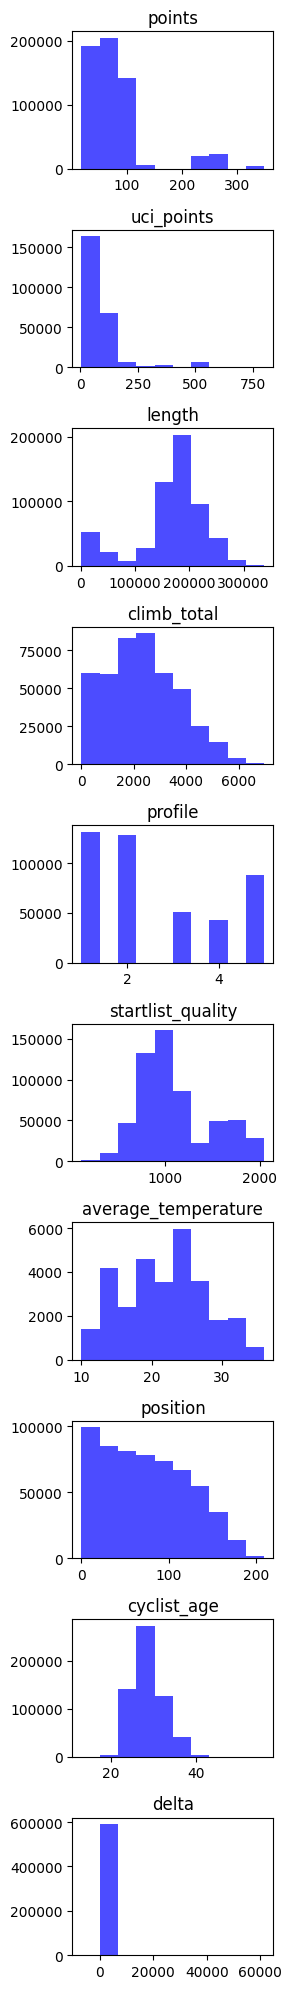

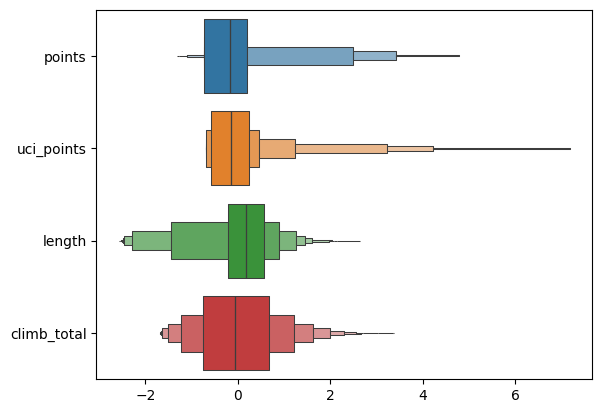

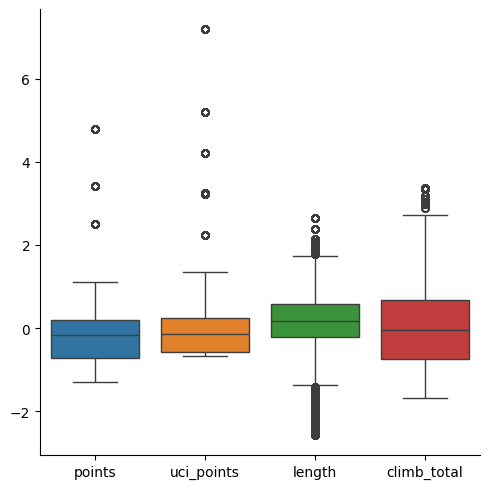

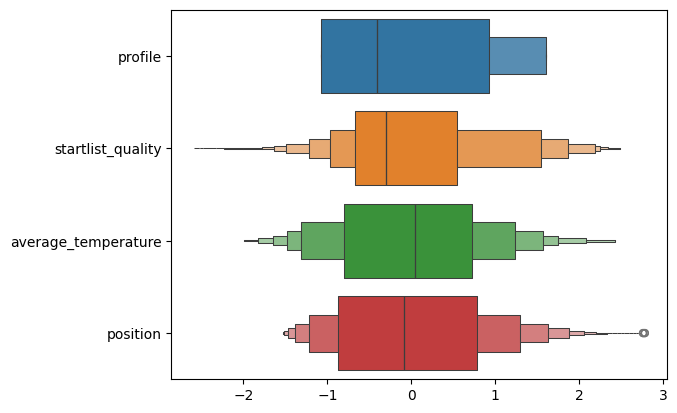

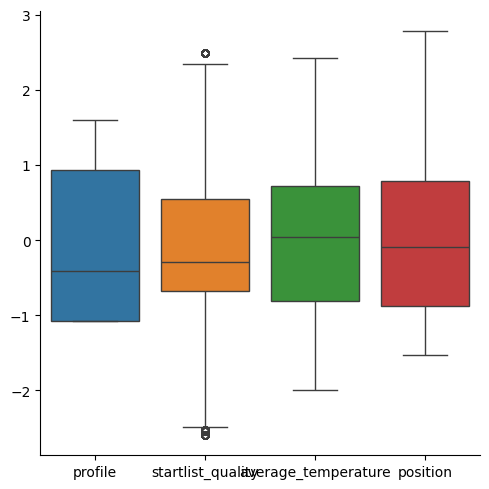

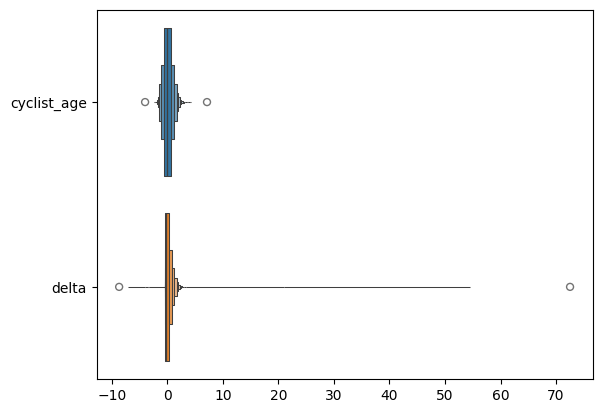

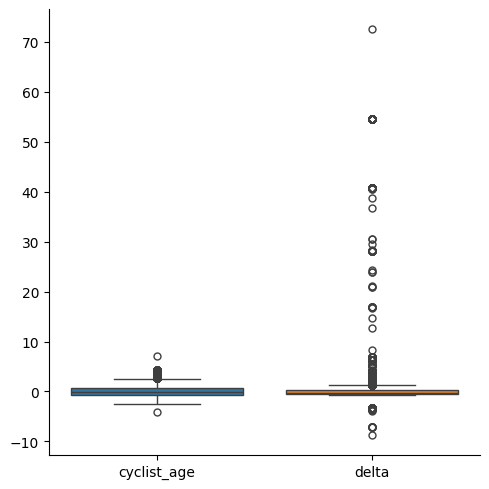

In [16]:
InterestingFeatures = ["points", "uci_points", "length", "climb_total", "profile",
                       "startlist_quality", "average_temperature", "position", "cyclist_age", "delta"]

PlotDistributionFeatures(DatasetRace, InterestingFeatures)

Nella maggior parte delle colonne ci sono distribuzioni non uniformi e la presenza di outlier è sopratutto su "delta", "cyclists_age" e "climb_total" 

### Correlations between features (Oleskiy)

### Conclusions

Per la prossima fase di data transformation, sono state decise le seguenti decisioni per il dataset **race**:

- 

# **Data cleaning**

## Dataset cyclists

### Fill nationality data missing

Si va a riempire il dato mancante nella colonna "nationality", il valore è stato cercato su Google.

In [17]:
ScottDavisIndex = DatasetCyclists[DatasetCyclists["nationality"].isnull()].index[0]
DatasetCyclists.loc[ScottDavisIndex, "nationality"] = "Great Britain"

### Fill data of weight and height columns

Si va a riempire le colonne di "height" e "weight" sfruttando i dati tra loro. Si è scoperto che hanno un alta correlazione.

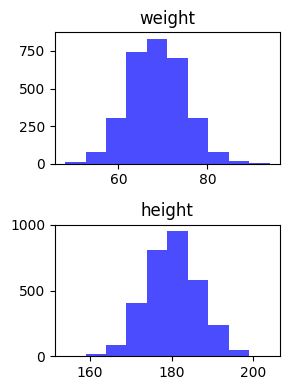

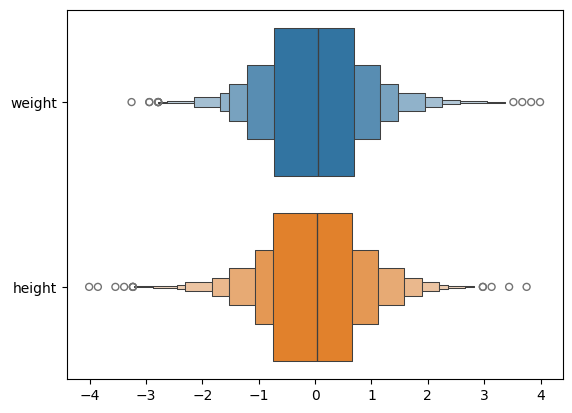

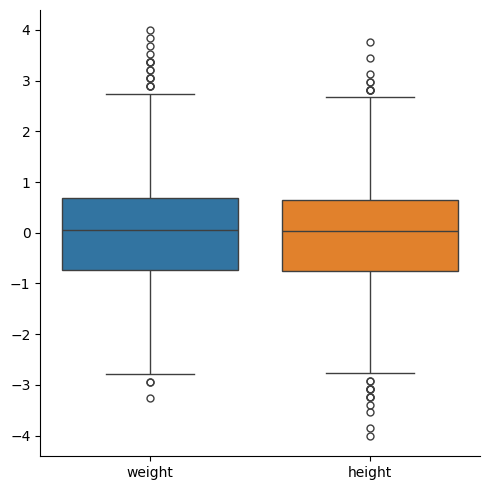

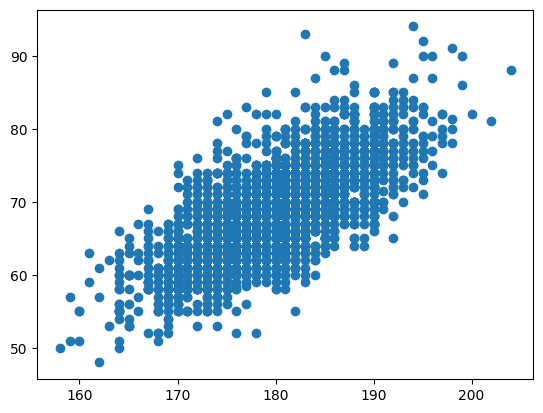

In [18]:
#Inferenza sulle colonne weight ed height
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle 2 colonne tra loro.

In [19]:
TrainData = DatasetCyclists.dropna(subset=['weight', 'height'])

#Predizione dei valori sulle righe dove height c'è e weight manca (regressore lineare) e viceversa (con un altro regressore lineare)
HeightPredictor = LinearRegression()
WeightPredictor = LinearRegression()

#Allenamento dei regressori
for _ in range(1):
    HeightPredictor.fit(TrainData[['weight']], TrainData[['height']])
    WeightPredictor.fit(TrainData[['height']], TrainData[['weight']])

#Calcolo degl' indici dove andare a riempire i valori
HeightSlot = DatasetCyclists[DatasetCyclists['height'].isna() & DatasetCyclists['weight'].notna()]
WeightSlot = DatasetCyclists[DatasetCyclists['weight'].isna() & DatasetCyclists['height'].notna()]

#Calcolo dei valori mancanti
DatasetCyclists.loc[WeightSlot.index, 'weight'] = WeightPredictor.predict(WeightSlot[['height']])
DatasetCyclists.loc[HeightSlot.index, 'height'] = HeightPredictor.predict(HeightSlot[['weight']])

#Predizione dei valori sulle righe dove manca sia height che weight (distribuzione)
ColumnsCleaned = DatasetCyclists[["weight", "height"]].dropna()

#Creazione della distribuzione multivariata (2 dimensioni)
Distribution = multivariate_normal([ColumnsCleaned["weight"].mean(), ColumnsCleaned["height"].mean()],
                                   np.cov(ColumnsCleaned["weight"], ColumnsCleaned["height"]))

#Calcolo degl' indici dei valori missing
MissingIndex = DatasetCyclists[DatasetCyclists[['weight', 'height']].isna().any(axis=1)].index

#Riempimento dei valori mancanti con la distribuzione multivariata
DatasetCyclists.loc[MissingIndex, ['weight', 'height']] = Distribution.rvs(size=len(MissingIndex))


Si allena un regressore lineare per inferire sui dati "weight".
Si allena un regressore lineare per inferire sui dati "height".

Per i regressori si prepara un insieme di dati che sono le coppie dove ci sono entrambi i valori.

Si costruisce una distribuzione multivariata (2 dimensioni) usando i dati a disposizione + i dati inferiti con i regressori, dopodichè si campionano dei dati per poter inferire sui dati mancanti.

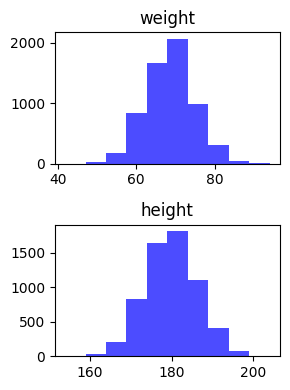

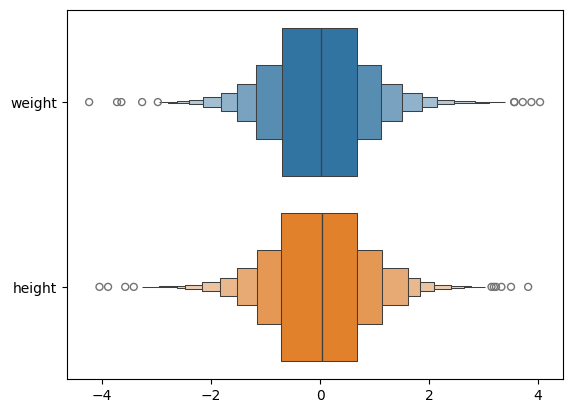

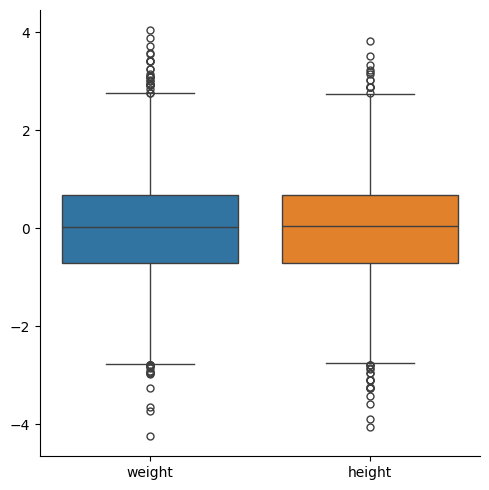

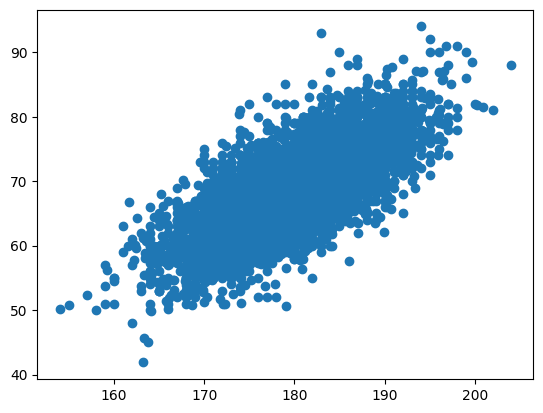

In [20]:
PlotDistributionFeatures(DatasetCyclists, ["weight", "height"])
plt.scatter(DatasetCyclists["height"], DatasetCyclists["weight"])

Si mostrano le distribuzioni e correlazioni delle colonne tra loro dopo il riempimento dei dati mancanti.

### Fill data of birth_year column (Riccardo)

### View final dataset cleaned

             Total values  Missing values  Usable values
Elements                                                
_url                 6134               0           6134
name                 6134               0           6134
birth_year           6134              13           6121
weight               6134               0           6134
height               6134               0           6134
nationality          6134               0           6134


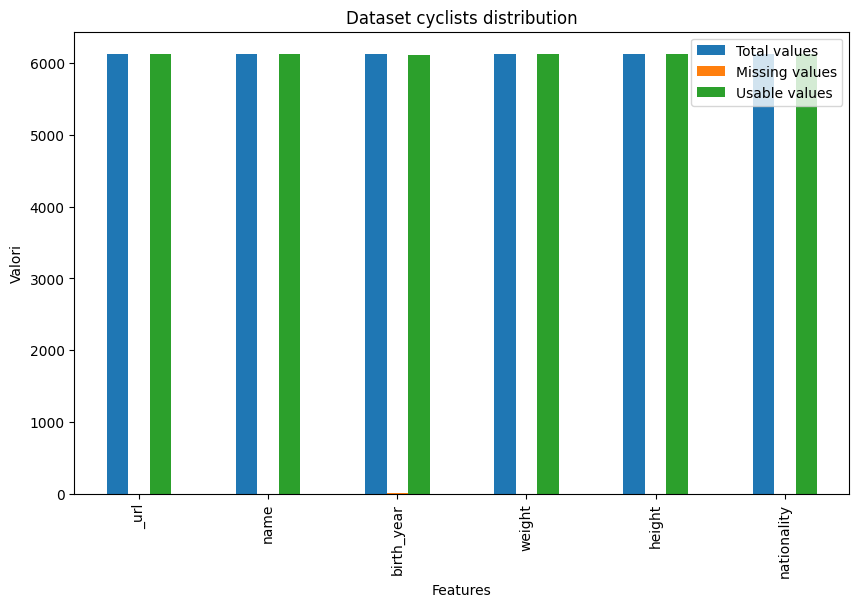

In [21]:
PlotMissingUsableData(DatasetCyclists, "cyclists")

## Dataset race

### Delete average_temperature feature

Si toglie la tabella "average_temperature", è irrilevante e non ha nessuna correlazione con altre tabelle.

In [22]:
#Tolgo la feautres average_temperature
del DatasetRace["average_temperature"]

### Fill data of climb_total and profile columns (Oleskiy)

### Fill data of points and uci_points columns (Oleskiy)

### Fill data of cyclists_age and cyclists_team columns (Riccardo)

### View final dataset cleaned

                   Total values  Missing values  Usable values
Elements                                                      
_url                     589865               0         589865
name                     589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0         589865
cyclist                  589865               0         589865
cyclist_age              589865             113         589752
is_tarmac                589865               0         589865
is_cobbled               589865               0        

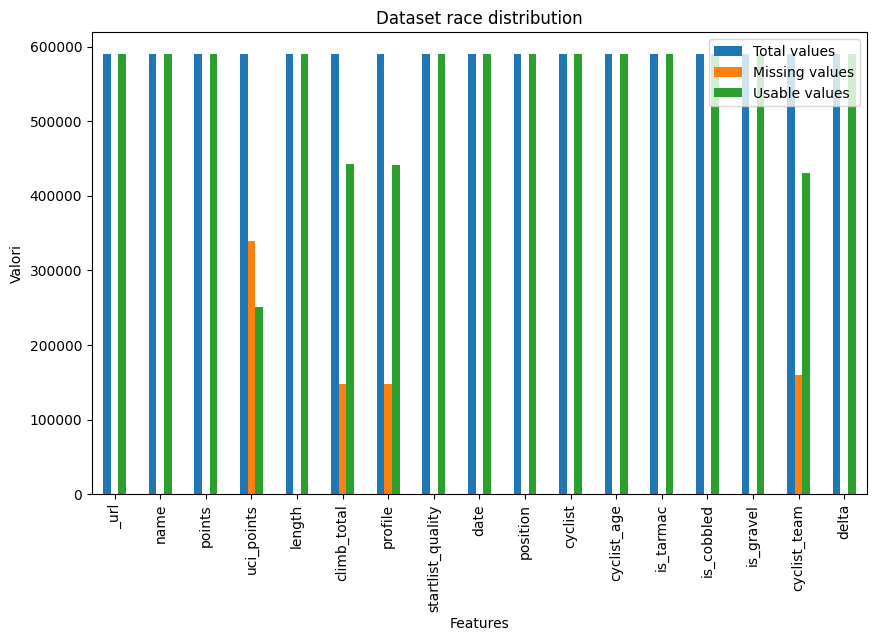

In [23]:
PlotMissingUsableData(DatasetRace, "race")

# **Feature engineering**

Si fa il merge delle tabelle in un unica tabella, prendendo come chiavi di riferimento la colonna "_url" del dataset cyclists e la colonna "cyclists" del dataset race.

                   Total values  Missing values  Usable values
Elements                                                      
name_cyclist             589865               0         589865
birth_year               589865             113         589752
weight                   589865               0         589865
height                   589865               0         589865
nationality              589865               0         589865
name_race                589865               0         589865
points                   589865             477         589388
uci_points               589865          338779         251086
length                   589865               0         589865
climb_total              589865          147045         442820
profile                  589865          148194         441671
startlist_quality        589865               0         589865
date                     589865               0         589865
position                 589865               0        

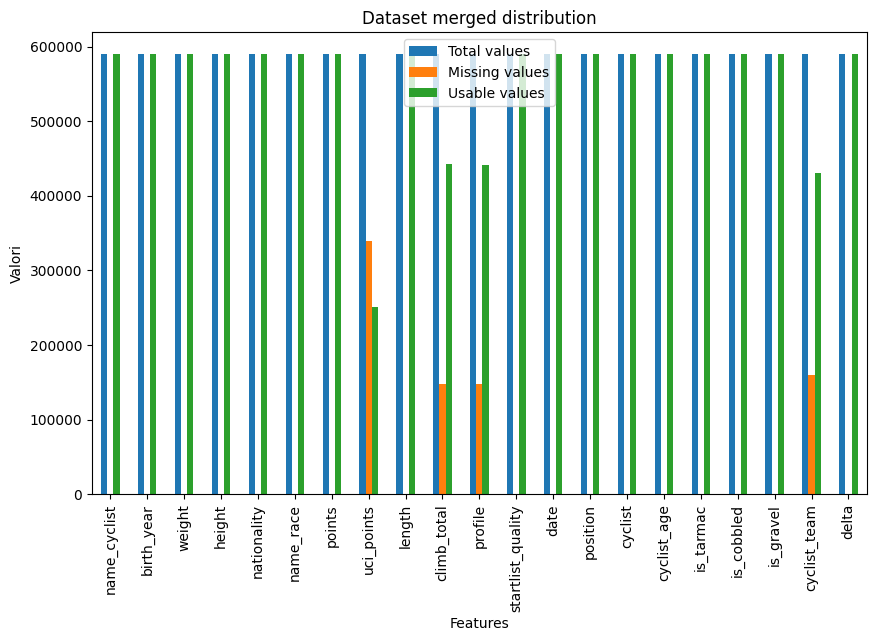

In [24]:
MergeDataset = pd.merge(DatasetCyclists, DatasetRace, left_on = "_url", right_on = "cyclist")

del MergeDataset["name_x"]
del MergeDataset["name_y"]

MergeDataset.rename(columns = {"_url_x": "name_cyclist"}, inplace = True)
MergeDataset.rename(columns = {"_url_y": "name_race"}, inplace = True)

PlotMissingUsableData(MergeDataset, "merged")

# - (Analysis a choosed situation)